# Autocaptioning with Modelception

This notebook shows a quick walkthrough of the caption generation pipeline.

1. (region proposal) Run GLIP to detect relevant objects and get crops using the bounding boxes
2. (caption per region) Use BLIP2 to generate captions for each crop
3. (filtering) Get the CLIP similarities between every caption and every crop and choose the best caption for each crop
4. (filtering) Throw away the captions that do not have the highest cosine similarities with their crop
5. (summarization) Ask GPT4 to remove any outliers
6. (summarization) Ask GPT4 to generate a final caption for the entire image



The repository is self-contained. To use, follow these steps:
- In a virtual env, `pip install -r requirements.txt`
- Set the [OpenAI API key](https://platform.openai.com/account/api-keys), `export OPENAI_API_KEY=<your-key-here>`

To see the GLIP model in action, simply run
```
python glip_client.py
```

To use the CaptionGenerator outside of this notebook, simply run
```
python CaptionGenerator.py
```

In [1]:
# ! $OPENAI_API_KEY

In [1]:
from PIL import Image
import dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
from CaptionGenerator import CaptionGenerator

/home/andre/anaconda3/envs/caption/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the caption generator
print("Loading caption generator")
dotenv.load_dotenv(".env", override=True)
openai_key =  os.getenv("OPENAI_API_KEY")
device = 'cuda:0'

Loading caption generator


## CaptionGenerator

The CaptionGenerator class uses a combination of GLIP, CLIP, BLIP2, and GPT-4/3.5. The relevant knobs are as follows:

- `verbose` prints all relevant entities. Recommended for debugging.
- `gpt4=True` uses the GPT-4 API. If you don't have access, set to False (uses gpt-3.5-turbo).
- `topk` refers to the number of objects used for generating the final caption. Set to `-1` for all objects, note that this may lead to very descriptive captions that refer to the smallest of entities.
- `filter` refers to the CLIP filtering pipeline, where the BLIP2 captions are "verified" using a second, independent model (CLIP). Seems to help somewhat, but slow.

The inference time on the notebook is representative of the actual inference time, but it can likely be faster when used directly in python (Jupyter notebooks can be slow).

### Base pipeline, fastest

- `filter=False`
- `topk=5`

_Typical inference time: 8 seconds_

In [6]:
cg = CaptionGenerator(openai_key, device, verbose=True, filter=False, topk=5, gpt4=True)

CaptionGenerator VERBOSE
Filtering TRUE
Topk 5
Device cuda:0
Using GPT4
cuda:0
cuda:0


In [5]:
# recursively search the directory for images
# import os
# import glob

# def get_image_paths(root_dir):
#     image_paths = []
#     for root, dirs, files in os.walk(root_dir):
#         for file in files:
#             if file.endswith(".jpg"):
#                 image_paths.append(os.path.join(root, file))
#     return image_paths

# # img_paths = get_image_paths('/nfs/kun2/users/homer/datasets/bridge_data_all/raw/bridge_data_v2/datacol1_toykitchen6/pnp_sweep/20')
# img_paths = get_image_paths('/nfs/kun2/users/homer/datasets/bridge_data_all/raw/bridge_data_v2')
# print(len(img_paths))

In [6]:
# save img paths
# with open('img_paths.txt', 'w') as f:
#     for item in img_paths:
#         f.write(item + '\n')

In [3]:
# load img paths
with open('img_paths.txt', 'r') as f: 
    img_paths = f.readlines()
    img_paths = [x.strip() for x in img_paths]
np.random.shuffle(img_paths)
img_paths[:5]

['/nfs/kun2/users/homer/datasets/bridge_data_all/raw/bridge_data_v2/datacol1_toykitchen6/fold_cloth/22/2023-03-04_18-42-31/raw/traj_group0/traj16/images0/im_10.jpg',
 '/nfs/kun2/users/homer/datasets/bridge_data_all/raw/bridge_data_v2/datacol2_robot_desk/fold_cloth/43/2023-02-14_15-35-24/raw/traj_group0/traj3/images0/im_28.jpg',
 '/nfs/kun2/users/homer/datasets/bridge_data_all/raw/bridge_data_v2/datacol2_robot_desk/fold_cloth/15/2023-02-13_13-47-05/raw/traj_group0/traj3/images0/im_14.jpg',
 '/nfs/kun2/users/homer/datasets/bridge_data_all/raw/bridge_data_v2/datacol2_tabletop_dark_wood/many_skills/20/2023-03-04_20-24-15/raw/traj_group0/traj22/images0/im_21.jpg',
 '/nfs/kun2/users/homer/datasets/bridge_data_all/raw/bridge_data_v2/datacol2_laundry_machine/pnp_sweep/23/2023-02-11_19-08-38/raw/traj_group0/traj11/images0/im_0.jpg']

(-0.5, 511.5, 511.5, -0.5)

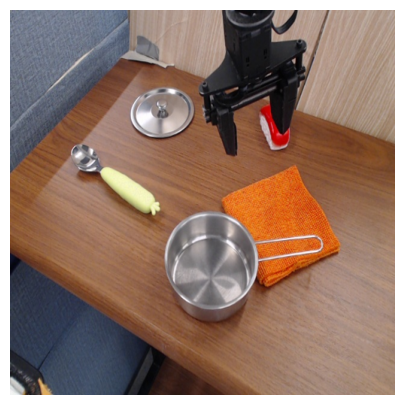

In [8]:
img_path = img_paths[21]
image = Image.open(img_path)
image = image.resize((512, 512))
if image.mode == 'RGBA':
    image = image.convert('RGB')
# set figure size
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')

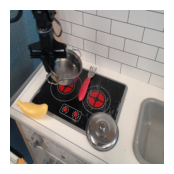

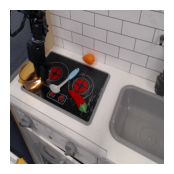

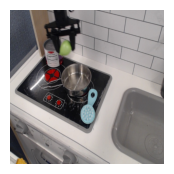

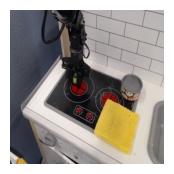

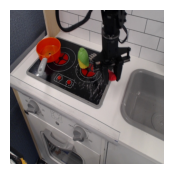

In [8]:
scene = 'datacol2_toykitchen6'
scene_img_paths = [path for path in img_paths if scene in path]
initial_img_paths = [path for path in scene_img_paths if path.endswith('im_0.jpg')]

# show 5 random images from the scene
examples = []
for i in range(5):
    img_path = np.random.choice(scene_img_paths)
    image = Image.open(img_path)
    image = image.resize((512, 512))
    if image.mode == 'RGBA':
        image = image.convert('RGB')
    examples.append(image)
    # set figure size
    plt.figure(figsize=(2,2))
    plt.imshow(image)
    plt.axis('off')


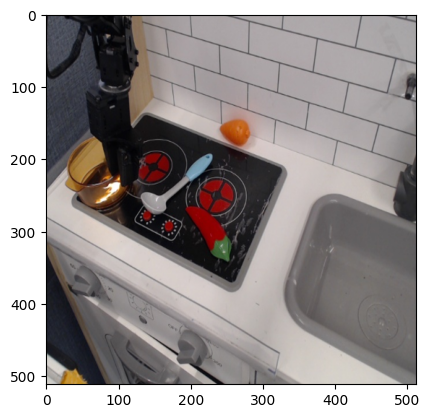

In [9]:
image = examples[1]
plt.imshow(image)

In [11]:
# plot the image with bounding boxes
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", 40)

def draw_bounding_boxes(image, bboxes, labels, captions):
    # dont draw on original image
    image = image.copy()
    draw = ImageDraw.Draw(image)
    for i, bbox in enumerate(bboxes):
        x1, y1, x2, y2 = bbox
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        draw.text((x1, y1), labels[i], font=fnt, fill="yellow")
        # draw.text((x1, y1+20), captions[i], (0, 0, 0), size=20)
    return image

Getting objects
Getting crops
Generating caption for crop
Generating caption for crop
Generating caption for crop
Generating caption for crop
Generating caption for crop
Generating caption for crop
Generating caption for crop
Calling GPT
A kitchen featuring a stove top and sink, with various utensils such as a bowl, spoon, and spatula, as well as a carrot and knife present.
['table', 'countertop', 'sink', 'pot', 'spatula', 'pepper', 'carrot']


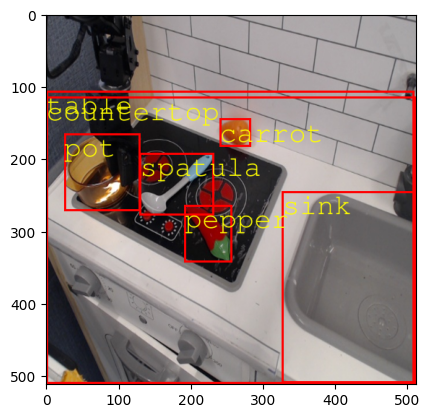

In [12]:
# Generate a caption
cg.topk = 100
words = ['spatula', 'carrot', 'pot', 'countertop', 'mechanical arm', 'sink', 'stove', 'pepper', 'table', 'knife', 'towel', 'sushi']
# words = ['mechanical arm']
cg.set_words(words)
caption = cg.caption_image(image)
print(caption)
crops = caption.unsorted_crops
text_labels = caption.labels
captions = caption.captions
remapped_captions = caption.remapped_captions
bboxes = caption.bboxes


print(text_labels)
bimage = draw_bounding_boxes(image, bboxes, text_labels, captions)
plt.imshow(bimage)

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/andre/autocaptioning-modelception/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

['table', 'countertop', 'countertop', 'sink', 'pot', 'knife', 'spatula', 'pepper', 'carrot', 'pepper']


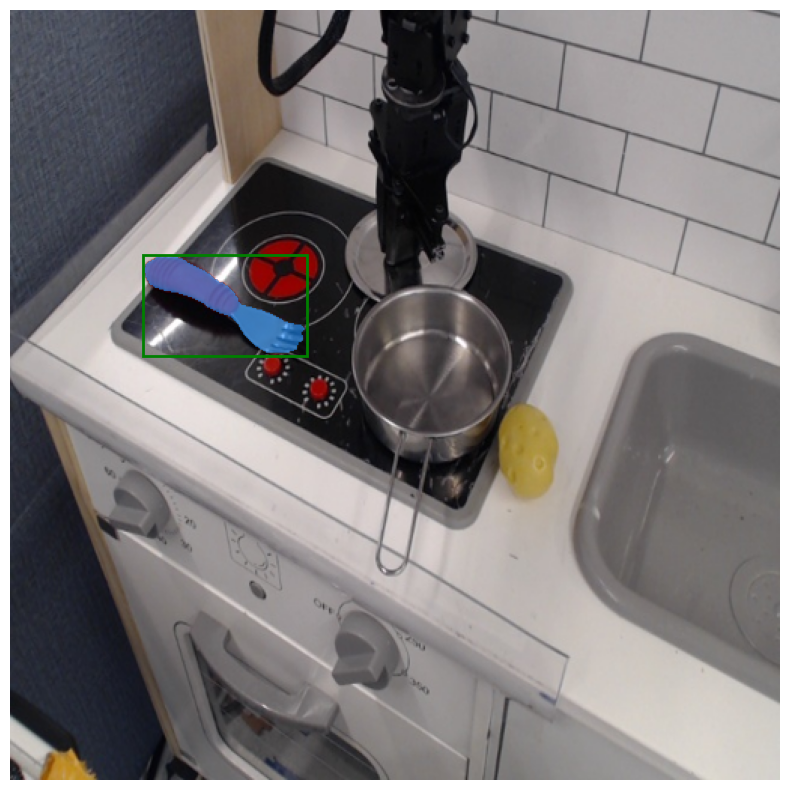

In [17]:
npimg = np.array(image)
predictor.set_image(npimg)
input_box = np.array(bboxes[6])
print(text_labels)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(npimg)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

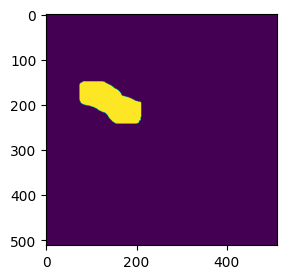

In [23]:
import cv2
# set figure size
mask = masks[0]
plt.figure(figsize=(3,3))
# plt.imshow(mask)

kernel = np.ones((3,3),np.uint8)
# Dilate the mask
dilated_mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations = 15)

plt.imshow(dilated_mask)

100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


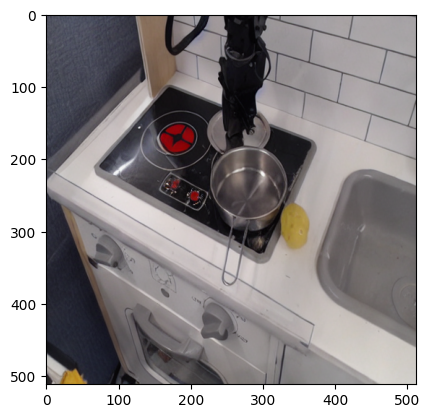

In [24]:
from diffusers import StableDiffusionInpaintPipeline

# pipe = StableDiffusionInpaintPipeline.from_pretrained(
#     "runwayml/stable-diffusion-inpainting",
#     revision="fp16",
#     torch_dtype=torch.float16,
# ).to(device)
output = pipe(prompt="", 
            image=npimg, 
            # mask_image=masks[0].astype(np.uint8),
            mask_image=dilated_mask,
            ).images[0]
plt.imshow(output)